# Random Forest Approach

1. Convert Business Problem to Data Science Problem
2. Load Data
3. Understand the Data
4. Data Preprocessing
5. Exploratory Data Analysis
6. Model Building
7. Predictions and Evaluations
8. Handle Class Imbalance
9. Hyperparameter Tuning

### 1. Problem Statement

Build a classification engine which predicts and classifies if a customer is going to repay the loan or not, based on various features like credit policy, interest rate, installements, revoloving balance etc.

In [1]:
# Import Modules
import pandas as pd
import numpy as np
pd.set_option('display.max_row', 800)
pd.set_option('display.max_column', 500)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

### 2. Load data

In [2]:
df = pd.read_csv('data.csv')

### 3. Understanding the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


**NOTE:** No missing data so we need not to deal with treatment of missing values.

In [4]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [5]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


**NOTE:** Here, **`not.fully.paid`** is our target variable which is in the form of 0's and 1's i.e. classification problem.

All other variables are the features that we will use in model building to train our model.

In [6]:
print(df.shape)

print(df['not.fully.paid'].value_counts())

(9578, 14)
0    8045
1    1533
Name: not.fully.paid, dtype: int64


In [7]:
# Identifying numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns

cat_cols = df.select_dtypes(exclude=np.number).columns

print(f"Numerical columns: {num_cols.values}\n")

print(f"Categorical columns: {cat_cols.values}")

Numerical columns: ['credit.policy' 'int.rate' 'installment' 'log.annual.inc' 'dti' 'fico'
 'days.with.cr.line' 'revol.bal' 'revol.util' 'inq.last.6mths'
 'delinq.2yrs' 'pub.rec' 'not.fully.paid']

Categorical columns: ['purpose']


**NOTE:** There is only one categorical column i.e. **`purpose`**. We will treat it later in data processing step.

### 4. Data pre-processing

In [8]:
# Let's do one hot encoding for the column `purpose` as model only accept numerical data.
df = pd.get_dummies(prefix='purpose', columns=['purpose'], data=df)

In [9]:
df.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


In [10]:
# Identifying numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns

cat_cols = df.select_dtypes(exclude=np.number).columns

print(f"Numerical columns: {num_cols.values}\n")

print(f"Categorical columns: {cat_cols.values}")

Numerical columns: ['credit.policy' 'int.rate' 'installment' 'log.annual.inc' 'dti' 'fico'
 'days.with.cr.line' 'revol.bal' 'revol.util' 'inq.last.6mths'
 'delinq.2yrs' 'pub.rec' 'not.fully.paid' 'purpose_all_other'
 'purpose_credit_card' 'purpose_debt_consolidation' 'purpose_educational'
 'purpose_home_improvement' 'purpose_major_purchase'
 'purpose_small_business']

Categorical columns: []


In [11]:
# check for num values in each column
print(df.isna().sum())

credit.policy                 0
int.rate                      0
installment                   0
log.annual.inc                0
dti                           0
fico                          0
days.with.cr.line             0
revol.bal                     0
revol.util                    0
inq.last.6mths                0
delinq.2yrs                   0
pub.rec                       0
not.fully.paid                0
purpose_all_other             0
purpose_credit_card           0
purpose_debt_consolidation    0
purpose_educational           0
purpose_home_improvement      0
purpose_major_purchase        0
purpose_small_business        0
dtype: int64


### 5. Exploratory data analysis

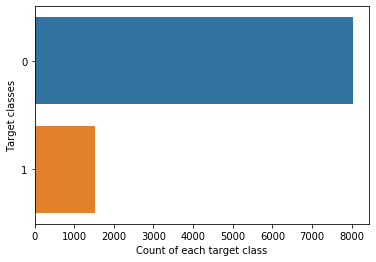

In [12]:
# Check the distribution of y variable to see it's a case of class imbalance.
sns.countplot(y=df['not.fully.paid'], data=df)
plt.xlabel('Count of each target class')
plt.ylabel('Target classes')
plt.show();

**NOTE:** There is huge class imbalance because the negative examples are much lareger than positive examples in quantity.

Around 15-20% of people doesn't repay the loan.

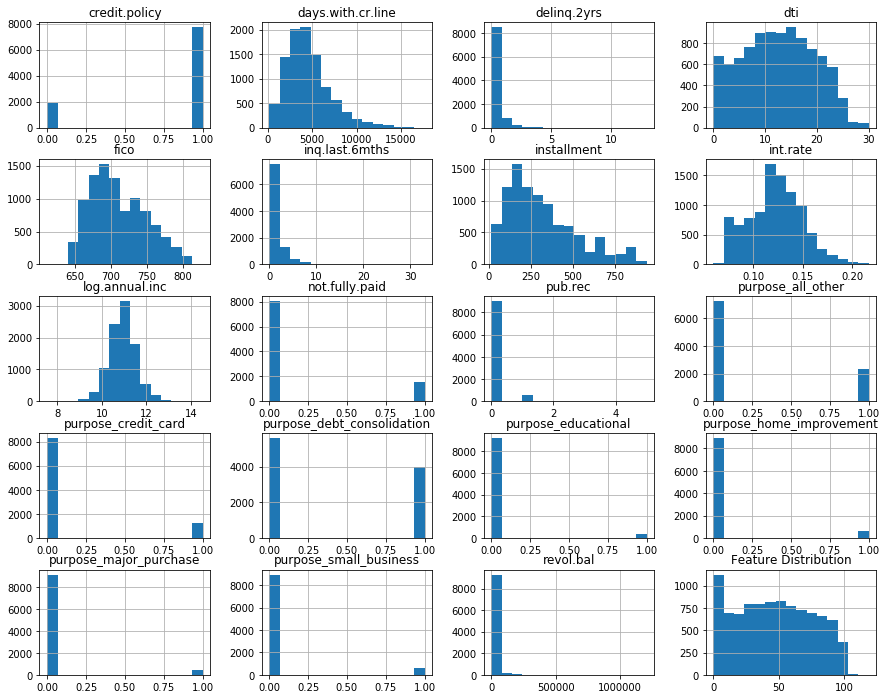

In [13]:
# Check the distribution of all features
df.hist(figsize=(15, 12), bins=15)
plt.title("Feature Distribution")
plt.show();

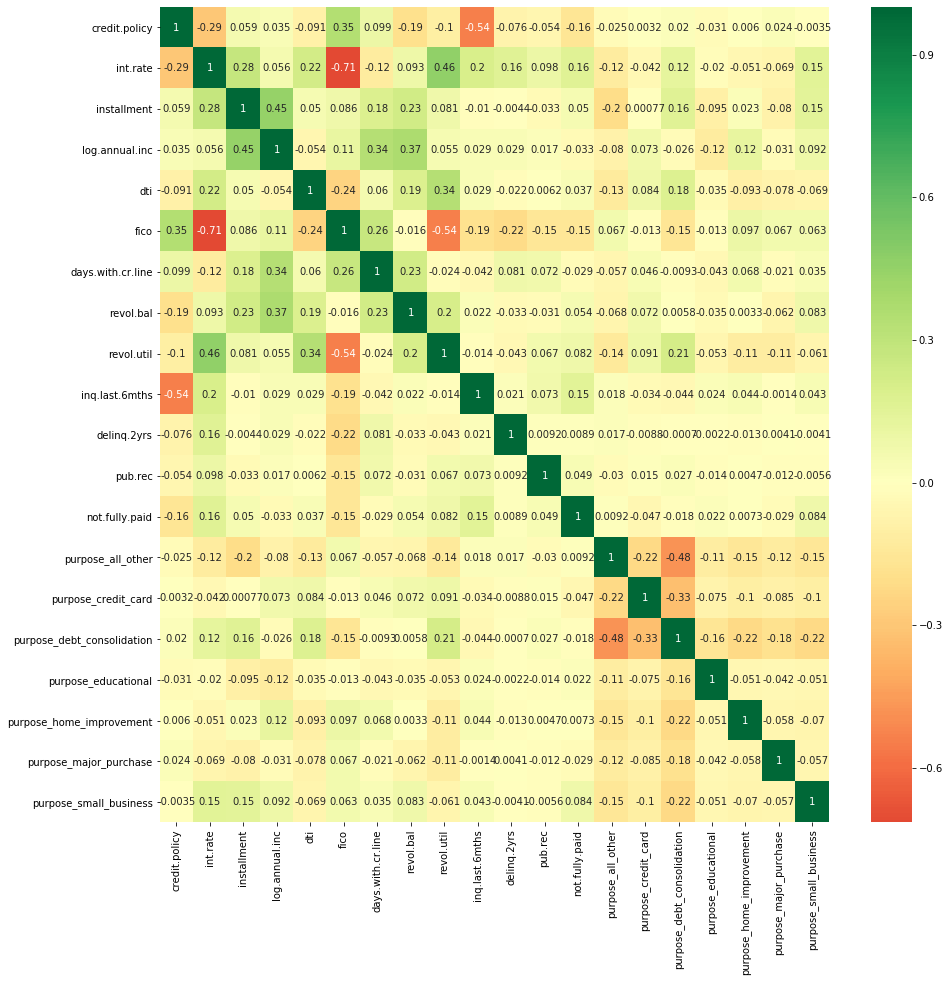

In [14]:
# Check the multicollinearity of features
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', center=0);

### 6. Model Building

In [15]:
X = df.drop(['not.fully.paid'], axis=1)
y = df['not.fully.paid']

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Random Forest Classifier**
* n_estimators: 50
* max_depth: 5

In [16]:
# Initialize the model and fit the data to the model
clf_1 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0)
clf_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=0)

**Random Forest Classifier**
* n_estimators: 100
* max_depth: 10

In [17]:
# Initialize the model and fit the data to the model
clf_2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf_2.fit(X_train, y_train);

### 7. Model Prediction and Evaluation

**Random Forest Classifier**
* n_estimators: 50
* max_depth: 5

In [18]:
# predict the target
y_pred_1 = clf_1.predict(X_test)

# evaluate
print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred_1)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred_1)}\n")
print(f"Classification report: \n {classification_report(y_test, y_pred_1)}")

Confusion matrix: 
 [[2408    0]
 [ 465    1]]

Accuracy score: 0.8382045929018789

Classification report: 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      2408
           1       1.00      0.00      0.00       466

    accuracy                           0.84      2874
   macro avg       0.92      0.50      0.46      2874
weighted avg       0.86      0.84      0.76      2874



**Random Forest Classifier**
* n_estimators: 100
* max_depth: 10

In [19]:
# predict the target
y_pred_2 = clf_2.predict(X_test)

print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred_2)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred_2)}\n")
print(f"Classification report: \n {classification_report(y_test, y_pred_2)}")

Confusion matrix: 
 [[2405    3]
 [ 460    6]]

Accuracy score: 0.8389004871259569

Classification report: 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      2408
           1       0.67      0.01      0.03       466

    accuracy                           0.84      2874
   macro avg       0.75      0.51      0.47      2874
weighted avg       0.81      0.84      0.77      2874



### 8. Handle class imbalance

As we have discussed earlier, class 0 is dominating class 1 which inturn results in class imbalance, we will do oversampling to resolve this issue.

In [20]:
# Handle class imbalance
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

y_ros.value_counts()

1    8045
0    8045
Name: not.fully.paid, dtype: int64

In [21]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.3, random_state=42)

**Random Forest Classifier**
* n_estimators: 50
* max_depth: 5

In [22]:
# Initialize the model and fit the data to the model
clf_1 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0)
clf_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=0)

**Random Forest Classifier**
* n_estimators: 100
* max_depth: 10

In [23]:
# Initialize the model and fit the data to the model
clf_2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf_2.fit(X_train, y_train);

In [24]:
# predict the target
y_pred_1 = clf_1.predict(X_test)

# evaluate
print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred_1)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred_1)}\n")
print(f"Classification report: \n {classification_report(y_test, y_pred_1)}")

Confusion matrix: 
 [[1647  797]
 [ 956 1427]]

Accuracy score: 0.6368344727574062

Classification report: 
               precision    recall  f1-score   support

           0       0.63      0.67      0.65      2444
           1       0.64      0.60      0.62      2383

    accuracy                           0.64      4827
   macro avg       0.64      0.64      0.64      4827
weighted avg       0.64      0.64      0.64      4827



In [25]:
# predict the target
y_pred_2 = clf_2.predict(X_test)

print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred_2)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred_2)}\n")
print(f"Classification report: \n {classification_report(y_test, y_pred_2)}")

Confusion matrix: 
 [[1833  611]
 [ 488 1895]]

Accuracy score: 0.7723223534286306

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      2444
           1       0.76      0.80      0.78      2383

    accuracy                           0.77      4827
   macro avg       0.77      0.77      0.77      4827
weighted avg       0.77      0.77      0.77      4827



### 9. Hyperparameter tunning

**NOTE:** Here, we will use GridSearchCV to try out different values of parameters and get the best combination out of it which gives maximum accuracy


In [26]:
clf = RandomForestClassifier()

# defining parameters values
param_grid = {'n_estimators':[100, 200, 300],
              'max_depth':[10, 20, 40]}

grid = GridSearchCV(clf, param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... max_depth=10, n_estimators=100, score=0.750, total=   1.3s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ...... max_depth=10, n_estimators=100, score=0.779, total=   1.3s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] ...... max_depth=10, n_estimators=100, score=0.759, total=   1.3s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.742, total=   1.3s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.773, total=   1.3s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.754, total=   2.8s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.778, total=   2.7s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.760, total=   2.5s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] ...... max_depth=10, n_estimators=200, score=0.745, total=   2.6s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.5min finished


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 40],
                         'n_estimators': [100, 200, 300]},
             verbose=3)

In [27]:
# get best estimators
print(grid.best_params_)

print(grid.best_estimator_)

{'max_depth': 40, 'n_estimators': 100}
RandomForestClassifier(max_depth=40)


In [28]:
# prediction with best parameters
grid_pred = grid.predict(X_test)

# model evaluation
print(f"Confusion matrix: \n {confusion_matrix(y_test, grid_pred)}\n")
print(f"Accuracy score: {accuracy_score(y_test, grid_pred)}\n")
print(f"Classification report: \n {classification_report(y_test, grid_pred)}")

Confusion matrix: 
 [[2313  131]
 [  30 2353]]

Accuracy score: 0.9666459498653408

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      2444
           1       0.95      0.99      0.97      2383

    accuracy                           0.97      4827
   macro avg       0.97      0.97      0.97      4827
weighted avg       0.97      0.97      0.97      4827



**SUMMARY**

In this problem, we prefer high recall model because our main focus here is to find out the people who are not going to repay the loan so that the bank can take future decisions based on our predictions. 
So, If our model is not able to predict the people who will not repay the loan, it is of no use.

In terms of recall, If we predict that a person will repay the loan and our prediction is wrong, than it will be a loss to the bank because bank is going to issue loan to the person who would not repay the loan. Therefore, we need a high recall model which correctly predicts the people who could do fraud with the bank. 

If we think in terms of precision, If the model predicts a person as fraud(not repay the loan), and if our model is wrong in actual, then bank end up lossing the customer because bank will not going to issue loan to the person. 

**REFRENCES**

**`Recall:`** Out of all the people who failed to repay the loan, how many of them were predicted correctly.

**`Precision:`** Out of all the people who were predicted to fail to repay the loan, how many of them are acutally not paid the loan.